# Import des outils / jeu de données

In [370]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import statsmodels.api as sm

In [371]:
np.random.seed(0)
sns.set_theme()

In [372]:
df = pd.read_csv(
    "data/data-cleaned-feature-engineering.csv",
    sep=",",
    index_col="ID",
    parse_dates=True,
)

In [373]:
df_transforme = pd.read_csv(
    "data/data-transformed.csv",
    sep=",",
    index_col="ID",
    parse_dates=True,
)

## Variables globales

In [374]:
var_numeriques = [
    "Year_Birth",
    "Income",
    "Recency",
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth",
]

In [375]:
var_categoriques = [
    "Education",
    "Marital_Status",
    "Kidhome",
    "Teenhome",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response",
]

# Régressions

In [376]:
from sklearn.model_selection import train_test_split

## Régression logistique

In [377]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

In [378]:
X = df[var_numeriques]

In [379]:
y = df[["Response"]].astype(int)

In [380]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [381]:
log_reg = LogisticRegression(random_state=0)

In [382]:
log_reg.fit(X_train, y_train)

c:\Users\jules\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jules\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [383]:
y_pred = log_reg.predict(X_test)

In [384]:
print(classification_report(y_test, y_pred, labels=log_reg.classes_))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       340
           1       0.53      0.13      0.21        69

    accuracy                           0.83       409
   macro avg       0.69      0.55      0.56       409
weighted avg       0.79      0.83      0.79       409



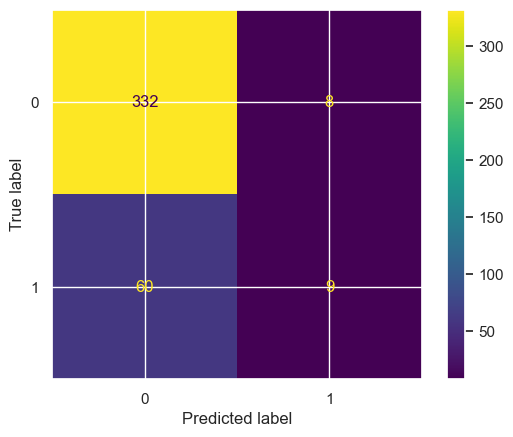

In [385]:
cm = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot()

In [386]:
# todo: commenter

## Régression PLS

In [387]:
# todo: refaire la régression PLS mais PAS sur une variable catégorique (erreur ici)

In [388]:
from sklearn.cross_decomposition import PLSRegression

In [389]:
# Initialisation de l'objet PLSRegression avec 2 composantes PLS
pls = PLSRegression(n_components=2)

In [390]:
# Apprentissage du modèle sur les données
pls.fit(df_transforme[var_numeriques], df_transforme["Response"])

PLSRegression()

In [391]:
# Prédiction de la variable cible sur de nouvelles données
y_pred = pls.predict(df_transforme[var_numeriques])

In [392]:
# Evaluation de la performance du modèle
r2 = pls.score(df_transforme[var_numeriques], df_transforme["Response"].astype(int))

In [393]:
r2

0.1449182118066641

## Régression linéaire simple

Modèle simple : une variable à expliquer $Y$ et une seule variable explicative $X$.

$$y_i = \beta_0 + \beta_1 X_i + \epsilon_i$$

Hypothèses à vérifier pour la régression linéaire simple :

1) il existe une corrélation linéaire entre $X$ et $Y$

1) la distribution de l’erreur $\epsilon$ est indépendante de la variable X (exogénéité)

2) l'erreur suit une loi normale centrée i.e. $E(ε_i) = 0$

3) l’erreur est de variance constante (homoscédasticité)
i.e $Var(ε_i) = \sigma^2$, une constante

4) les erreurs sont indépendantes (absence d'autocorrélation)
i.e. $Cov(εi, εj) = 0$, pour tout $i, j \in N \times N, i \neq j$

In [394]:
X = np.array(df_transforme["Income"])
Y = np.array(df_transforme["NumStorePurchases"])

### Hypothèse 1 : corrélation linéaire

In [395]:
from scipy.stats import pearsonr

In [396]:
print(
    "Le coefficient de corrélation linéaire entre X et Y vaut",
    pearsonr(X, Y)[0],
    "la pvalue associée vaut",
    pearsonr(X, Y)[1],
    "il existe donc bien une relation linéaire entre X et Y.",
)

Le coefficient de corrélation linéaire entre X et Y vaut 0.6790710752806038 la pvalue associée vaut 1.3161539637591645e-276 il existe donc bien une relation linéaire entre X et Y.


Le reste des hypothèses à tester requiert d'effectuer la régression linéaire :

In [397]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [398]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [399]:
model = LinearRegression().fit(X_train.reshape(-1, 1), Y_train)
Y_train_hat = model.predict(X_train.reshape(-1, 1))

Text(0.5, 1.0, "Régression linéaire du nombre d'achats en magasin en fonction du revenu")

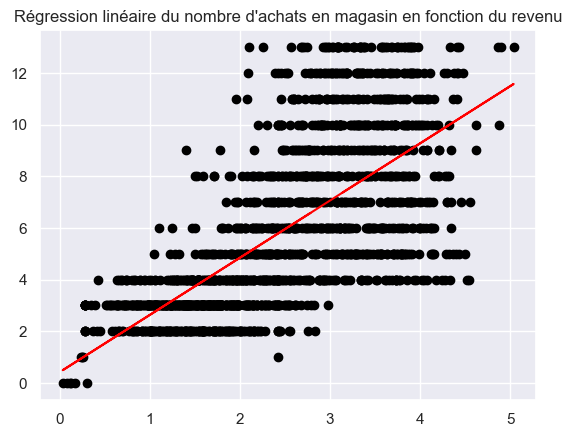

In [400]:
plt.scatter(X_train, Y_train, color="black")
plt.plot(X_train, Y_train_hat, color="red")
plt.title("Régression linéaire du nombre d'achats en magasin en fonction du revenu")

In [401]:
print(model.intercept_, model.coef_, model.score(X_train.reshape(-1, 1), Y_train))

0.41932027328891675 [2.21369643] 0.47029950823152755


Equation de régression :

$$y_i = 0.42 + 2.21 * x_i$$

### Hypothèse 2 : exogénéité

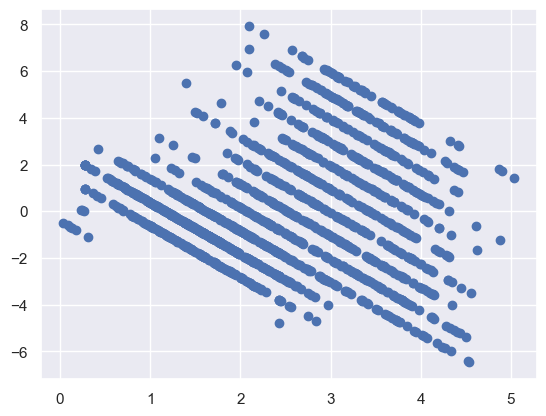

In [402]:
residuals = Y_train - Y_train_hat

plt.scatter(X_train, residuals)

In [403]:
print(
    "Le coefficient de corrélation entre X et les residus vaut",
    pearsonr(X_train, residuals)[0],
    ". On a bien indépendance et donc exogénéité.",
)

Le coefficient de corrélation entre X et les residus vaut -2.854704320154333e-16 . On a bien indépendance et donc exogénéité.


### Hypothèse 3 : l'erreur suit une loi normale centrée i.e. E(ε_i) = 0

In [404]:
import statistics
from scipy import stats

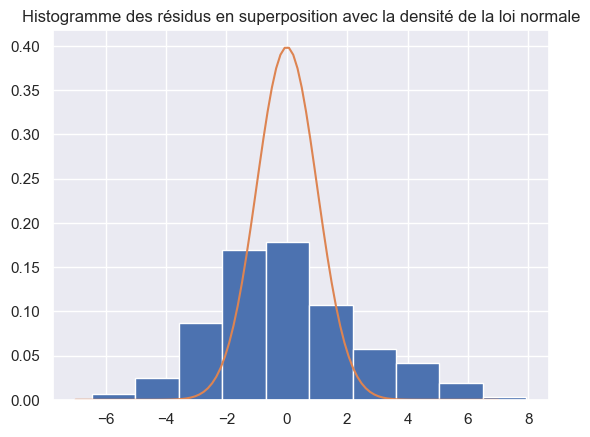

In [405]:
plt.hist(residuals, density=True)

x = np.linspace(-7, 7, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1))
plt.title("Histogramme des résidus en superposition avec la densité de la loi normale")
plt.show()

In [406]:
print("La moyenne des résidus vaut", statistics.mean(residuals))
print("Mais les résidus ne suivent pas une loi normale")

La moyenne des résidus vaut -5.35770830037629e-16
Mais les résidus ne suivent pas une loi normale


On constate sur le qqplot que les points ne suivent pas la droite x = y


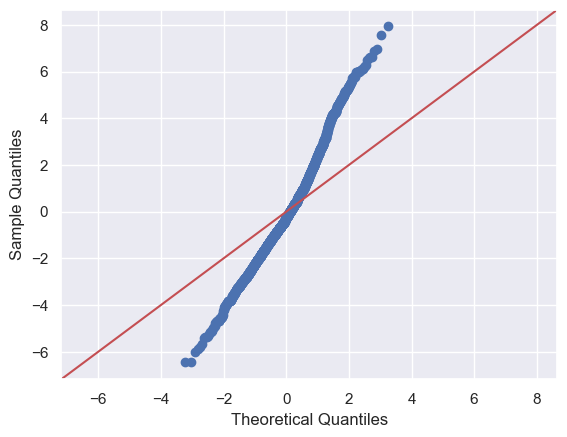

In [407]:
sm.qqplot(residuals, line="45")
print("On constate sur le qqplot que les points ne suivent pas la droite x = y")

In [408]:
print(
    "Un test de shapiro, pour tester l'hypothèse de normalité, nous donne une pvalue de",
    stats.shapiro(residuals)[1],
    ". On rejette l'hypothèse nulle et on conclut que les résidus ne suivent pas une loi normale.",
)

Un test de shapiro, pour tester l'hypothèse de normalité, nous donne une pvalue de 1.5231739480814355e-12 . On rejette l'hypothèse nulle et on conclut que les résidus ne suivent pas une loi normale.


### Hypothèse 4 : homoscédasticité

In [409]:
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, "-", color="red")

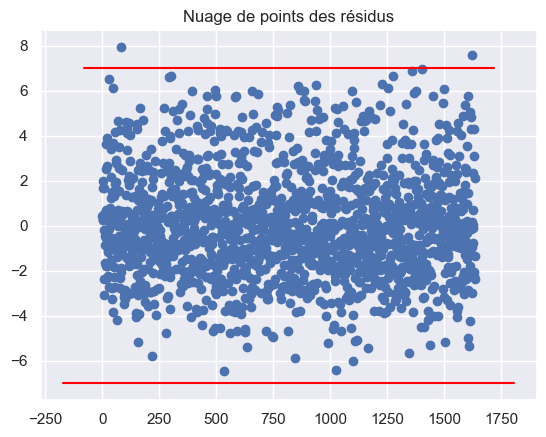

In [410]:
plt.plot(residuals, "bo")
plt.title("Nuage de points des résidus")
abline(0, 7)
abline(0, -7)

In [411]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

In [412]:
fit = sm.OLS(Y_train, sm.add_constant(X_train)).fit()

In [413]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     1451.
Date:                Sun, 26 Mar 2023   Prob (F-statistic):          9.81e-228
Time:                        23:02:38   Log-Likelihood:                -3726.4
No. Observations:                1636   AIC:                             7457.
Df Residuals:                    1634   BIC:                             7468.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4193      0.153      2.738      0.006       0.119       0.720
x1             2.2137      0.058     38.089      0.000       2.100       2.328
==============================================================================
Omnibus:                       51.217   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.343
Skew:                           0.447   Prob(JB):                     9.60e-13
Kurtosis:                       3.105   Cond. No.                         7.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [414]:
res_names = ["F statistic", "p-value"]
gq_test = sms.het_goldfeldquandt(fit.resid, fit.model.exog)
lzip(res_names, gq_test)

[('F statistic', 1.0633264046598985), ('p-value', 0.19033564154338742)]

In [415]:
bp_test = sms.het_breuschpagan(fit.resid, fit.model.exog)
lzip(res_names, bp_test)

[('F statistic', 222.40463115768435), ('p-value', 2.7032416707307303e-50)]

Le test de Goldfeld-Quandt ne nous donne pas d'hétéroscédasticité, contraiement au test de Breusch-Pagan.

### Hypothèse 5 : absence d'autocorrélation

In [416]:
from statsmodels.graphics.regressionplots import *

On remarque une absence d'autocorrélation.


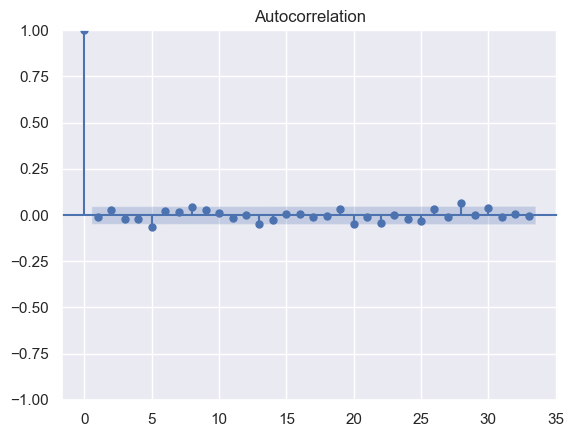

In [417]:
sm.graphics.tsa.plot_acf(residuals)
print("On remarque une absence d'autocorrélation.")

### Distance de Cook

In [418]:
influence = fit.get_influence()
cooks = influence.cooks_distance

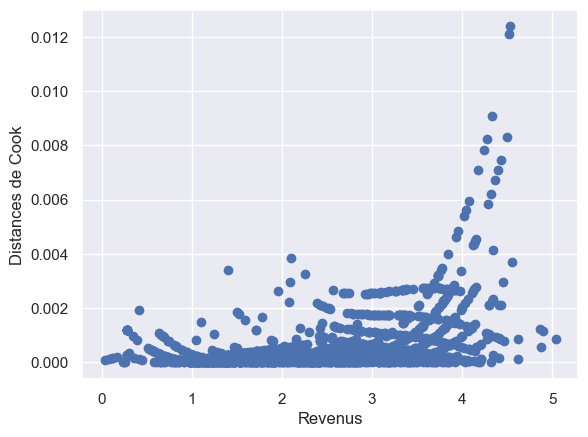

In [419]:
plt.scatter(X_train, cooks[0])
plt.xlabel("Revenus")
plt.ylabel("Distances de Cook")
plt.show()

In [420]:
cooks_indexes = [i for i, x in enumerate(cooks[0] > 0.010) if x]
print(cooks_indexes)
# affiche les indexes des individus dont les distances de cook dépassent une certaine valeur

[532, 1026]


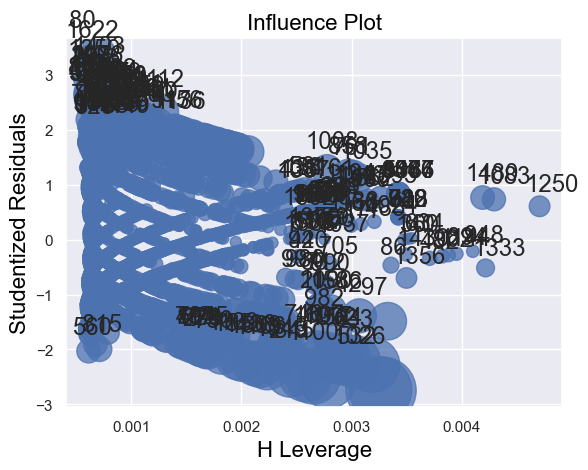

In [421]:
influence_plot(fit)
print("")

### Score du modèle

#### Qualité d'ajustement

In [422]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [423]:
print(f"Le R² du modèle vaut {model.score(X_train.reshape(-1, 1), Y_train)}")

Le R² du modèle vaut 0.47029950823152755


In [424]:
print(f"MSE = {mean_squared_error(Y_train, Y_train_hat)}")
print(f"RMSE = {mean_squared_error(Y_train, Y_train_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y_train, Y_train_hat)}")

MSE = 5.571127360403869
RMSE = 2.3603235711240673
MAE = 1.8519616230655271


#### Qualité de prédiction

Train / test split

In [425]:
print(
    f"R² du modèle sur les données d'entraînement = {model.score(X_train.reshape(-1, 1), Y_train)}"
)
print(
    f"R² du modèle sur les données de test = {model.score(X_test.reshape(-1, 1), Y_test)}"
)

R² du modèle sur les données d'entraînement = 0.47029950823152755
R² du modèle sur les données de test = 0.4225134353582901


In [426]:
Y_test_hat = model.predict(X_test.reshape(-1, 1))

Text(0.5, 1.0, "Nombre d'achats en magasin en fonction du revenu : données test")

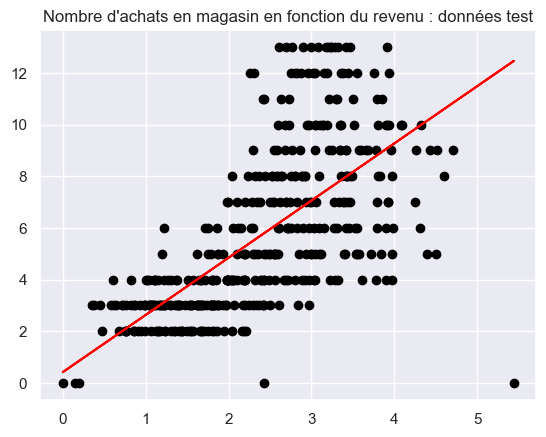

In [427]:
plt.scatter(X_test, Y_test, color="black")
plt.plot(X_test, Y_test_hat, color="red")
plt.title("Nombre d'achats en magasin en fonction du revenu : données test")

In [428]:
print(f"MSE = {mean_squared_error(Y_test, Y_test_hat)}")
print(f"RMSE = {mean_squared_error(Y_test, Y_test_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y_test, Y_test_hat)}")

MSE = 5.853872571999743
RMSE = 2.419477747779413
MAE = 1.8268826341039772


In [429]:
# todo: cross-validation

## Régression linéaire multiple

Modèle multiple : une variable à expliquer $Y$ et $P$ variables explicatives $X_i$

$$y_i = \beta_0 + \beta_1 X_i(1) + \beta_2 X_i(2) + \beta_3 X_i(3) + ... + \beta_P X_i(P) + \epsilon_i$$

Hypothèses à vérifier pour la régression linéaire multiple :

1) il existe une corrélation linéaire entre $X_i$ et $Y$

2) $Cov(X_i, ε_j) = 0$, pour tout $i, j \in N \times N, i \neq j$ (exogénéité) et pour chaque variable explicative $X_p$

3) l'erreur suit une loi normale centrée i.e. $E(ε_i) = 0$

4) l’erreur est de variance constante (homoscédasticité)
i.e $Var(ε_i) = \sigma^2$, une constante

5) les erreurs sont indépendantes (absence d'autocorrélation)
i.e. $Cov(εi, εj) = 0$, pour tout $i, j \in N \times N, i \neq j$

6) absence de colinéarité entre les variables explicatives,
i.e. $X^t * X$ est régulière, $det(X^t * X) \neq 0$

Pour les besoins de la régression linéaire, nous créons des variables muettes (dummy variables) pour inclure les variables catégoriques `Education` et `Marital_status` à la régression.

In [430]:
df_reg = df_transforme.copy()

In [431]:
df_reg = pd.get_dummies(df_reg, columns=["Education", "Marital_Status"])

In [432]:
df_reg.columns

Index(['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency',
       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
       'NbAcceptedCampaigns', 'HasAcceptedCampaigns', 'NbChildren',
       'Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow'],
      dtype='object')

Pour cette régression, on suppose que l'entreprise veut profiler au mieux les clients qui achètent dans le magasin. C'est pourquoi la variable d'intérêt pour la régression sera le `nombre d'achats en magasin`.

Nos variables explicatives sont des variables numériques et des variables catégoriques transformées en variables muettes.
Nous commençons par un grand nombre de variables explicatives puis nous en éliminerons progressivement pendant la vérifications des hypothèses.

In [433]:
var_numeriques_reg = [
    "Income",
    "Year_Birth",
    "Recency",
    "NbAcceptedCampaigns",
    "NumWebPurchases",
    "NumDealsPurchases",
    "NumWebVisitsMonth",
    "NumCatalogPurchases",
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
]

var_categoriques_reg = [
    "NbChildren",
    "Education_2n Cycle",
    "Education_Basic",
    "Education_Graduation",
    "Education_Master",
    "Education_PhD",
    "Marital_Status_Divorced",
    "Marital_Status_Married",
    "Marital_Status_Single",
    "Marital_Status_Together",
    "Marital_Status_Widow",
]

In [434]:
X = df_reg[var_categoriques_reg + var_numeriques_reg]
Y = df_reg["NumStorePurchases"]

In [435]:
print(
    "Nous avons",
    X.shape[1],
    "variables explicatives au début de la régression dont",
    X[var_numeriques_reg].shape[1],
    "variables numériques.",
)

Nous avons 25 variables explicatives au début de la régression dont 14 variables numériques.


### Hypothèse 1 : lien linéaire entre Y et les variables explicatives numériques

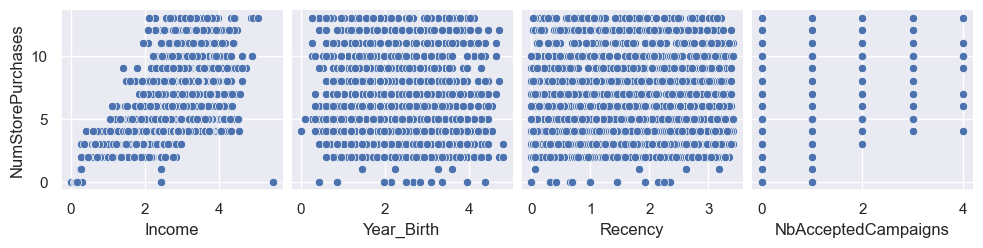

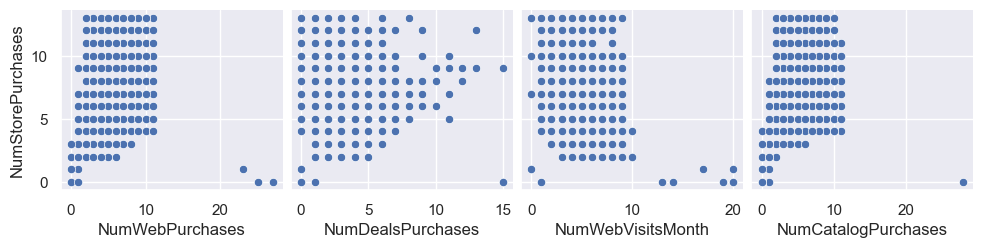

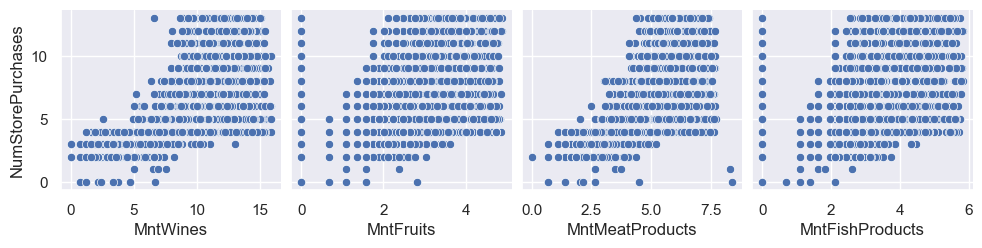

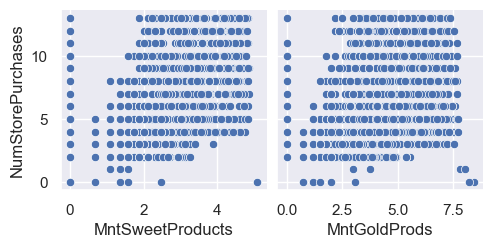

In [436]:
sns.pairplot(df_transforme, x_vars=var_numeriques_reg[0:4], y_vars="NumStorePurchases")
sns.pairplot(df_transforme, x_vars=var_numeriques_reg[4:8], y_vars="NumStorePurchases")
sns.pairplot(df_transforme, x_vars=var_numeriques_reg[8:12], y_vars="NumStorePurchases")
sns.pairplot(df_transforme, x_vars=var_numeriques_reg[12:], y_vars="NumStorePurchases")

In [437]:
for x in X[var_numeriques_reg].columns:
    corr = pearsonr(X[x], Y)
    print(
        "Le coefficient de corrélation linéaire entre Y et",
        x,
        "vaut",
        corr[0],
        "la pvalue vaut",
        corr[1],
    )

Le coefficient de corrélation linéaire entre Y et Income vaut 0.6790710752806038 la pvalue vaut 1.3161539637591645e-276
Le coefficient de corrélation linéaire entre Y et Year_Birth vaut -0.1452612037262372 la pvalue vaut 4.112323845048852e-11
Le coefficient de corrélation linéaire entre Y et Recency vaut 0.0014633262194708625 la pvalue vaut 0.9472714287541374
Le coefficient de corrélation linéaire entre Y et NbAcceptedCampaigns vaut 0.2123409758278407 la pvalue vaut 2.8026864212884285e-22
Le coefficient de corrélation linéaire entre Y et NumWebPurchases vaut 0.48685945140100195 la pvalue vaut 3.45783788946382e-122
Le coefficient de corrélation linéaire entre Y et NumDealsPurchases vaut 0.07208375232131882 la pvalue vaut 0.0011062951780020662
Le coefficient de corrélation linéaire entre Y et NumWebVisitsMonth vaut -0.4391931195077409 la pvalue vaut 3.4250524721831053e-97
Le coefficient de corrélation linéaire entre Y et NumCatalogPurchases vaut 0.5627033023451972 la pvalue vaut 3.924437

In [438]:
# TODO: faire un joli affichage avec SNS heatmap

On décide déjà d'écarter la variable `Recency` de la régression.

In [439]:
del X["Recency"]
var_numeriques_reg.remove("Recency")

### Réalisation du modèle

In [440]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [441]:
model_multiple = LinearRegression().fit(X_train, Y_train)
Y_train_hat = model_multiple.predict(X_train)

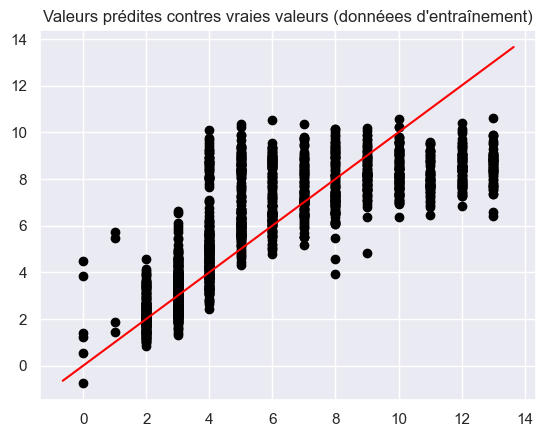

In [442]:
plt.scatter(Y_train, Y_train_hat, color="black")
plt.title("Valeurs prédites contres vraies valeurs (donnéees d'entraînement)")
abline(1, 0)

### Hypothèse 2 : exogénéité sur les variables numériques
(Cela n'a pas de sens de tester l'exogénéité sur les variables catégoriques car la notion de corrélation ne fonctionne pas avec celles-ci.)

In [443]:
residuals = Y_train - Y_train_hat

In [444]:
for x in X_train[var_numeriques_reg].columns:
    corr = pearsonr(X_train[x], residuals)
    print(
        "Le coefficient de corrélation entre",
        x,
        "et les residus vaut",
        corr[0],
        "et la pvalue associée vaut",
        corr[1],
    )

Le coefficient de corrélation entre Income et les residus vaut -8.230449741880586e-16 et la pvalue associée vaut 0.9999999999999747
Le coefficient de corrélation entre Year_Birth et les residus vaut 1.7580338226852454e-16 et la pvalue associée vaut 0.9999999999999919
Le coefficient de corrélation entre NbAcceptedCampaigns et les residus vaut -3.478662670419741e-16 et la pvalue associée vaut 0.9999999999999883
Le coefficient de corrélation entre NumWebPurchases et les residus vaut -2.693700297540236e-16 et la pvalue associée vaut 0.9999999999999919
Le coefficient de corrélation entre NumDealsPurchases et les residus vaut 3.3003114130458755e-16 et la pvalue associée vaut 0.9999999999999919
Le coefficient de corrélation entre NumWebVisitsMonth et les residus vaut 6.850260376306538e-16 et la pvalue associée vaut 0.9999999999999782
Le coefficient de corrélation entre NumCatalogPurchases et les residus vaut -7.53005513845495e-16 et la pvalue associée vaut 0.9999999999999782
Le coefficient de

Il n'y a pas d'endogénéité.

### Hypothèse 3 : l'erreur suit une loi normale centrée i.e. $E(ε_i) = 0$

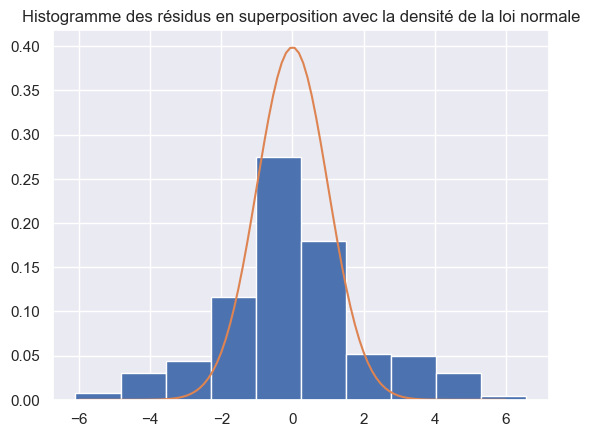

In [445]:
plt.hist(residuals, density=True)

x = np.linspace(-6, 6, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1))
plt.title("Histogramme des résidus en superposition avec la densité de la loi normale")
plt.show()

In [446]:
print("La moyenne des résidus vaut", statistics.mean(residuals))

La moyenne des résidus vaut -8.835638007713655e-16


On constate sur le qqplot que les points ne suivent pas la droite x = y


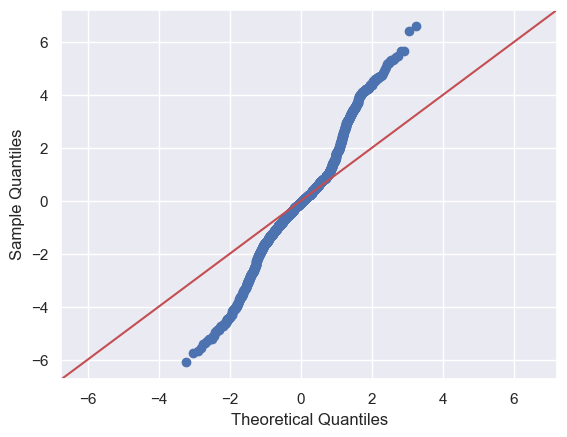

In [447]:
sm.qqplot(residuals, line="45")
print("On constate sur le qqplot que les points ne suivent pas la droite x = y")

In [448]:
print(
    "Un test de shapiro, pour tester l'hypothèse de normalité, nous donne une pvalue de",
    stats.shapiro(residuals)[1],
    ". On rejette l'hypothèse nulle et on conclut que les résidus ne suivent pas une loi normale.",
)

Un test de shapiro, pour tester l'hypothèse de normalité, nous donne une pvalue de 3.973341823017073e-16 . On rejette l'hypothèse nulle et on conclut que les résidus ne suivent pas une loi normale.


### Hypothèse 4 : homoscédasticité

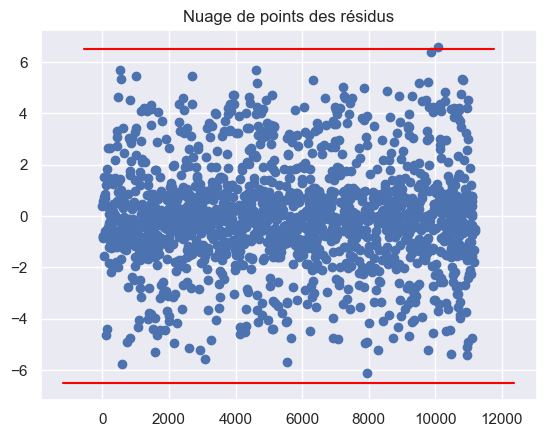

In [449]:
plt.plot(residuals, "bo")
plt.title("Nuage de points des résidus")
abline(0, 6.5)
abline(0, -6.5)

In [450]:
fit = sm.OLS(Y_train, sm.add_constant(X_train)).fit()

In [451]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      NumStorePurchases   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     120.9
Date:                Sun, 26 Mar 2023   Prob (F-statistic):          1.60e-321
Time:                        23:03:10   Log-Likelihood:                -3449.1
No. Observations:                1636   AIC:                             6944.
Df Residuals:                    1613   BIC:                             7068.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.1164      0.263      4.252      0.000       0.601       1.632
NbChildren                 -0.2059      0.099     -2.087      0.037      -0.399      -0.012
Education_2n Cycle          0.4084      0.166      2.455      0.014       0.082       0.735
Education_Basic             0.6801      0.288      2.361      0.018       0.115       1.245
Education_Graduation        0.0099      0.112      0.088      0.930      -0.211       0.230
Education_Master           -0.0326      0.139     -0.234      0.815      -0.306       0.240
Education_PhD               0.0506      0.136      0.372      0.710      -0.217       0.318
Marital_Status_Divorced     0.3121      0.150      2.076      0.038       0.017       0.607
Marital_Status_Married      0.3234      0.104      3.103      0.002       0.119       0.528
Marital_Status_Single       0.0786      0.121      0.650      0.516      -0.159       0.316
Marital_Status_Together     0.1935      0.113      1.713      0.087      -0.028       0.415
Marital_Status_Widow        0.2090      0.229      0.911      0.362      -0.241       0.659
Income                      0.2647      0.128      2.074      0.038       0.014       0.515
Year_Birth                  0.0576      0.055      1.043      0.297      -0.051       0.166
NbAcceptedCampaigns        -0.3867      0.084     -4.617      0.000      -0.551      -0.222
NumWebPurchases             0.0437      0.028      1.561      0.119      -0.011       0.099
NumDealsPurchases           0.1072      0.037      2.927      0.003       0.035       0.179
NumWebVisitsMonth          -0.1821      0.032     -5.618      0.000      -0.246      -0.119
NumCatalogPurchases        -0.1065      0.029     -3.639      0.000      -0.164      -0.049
MntWines                    0.4101      0.033     12.471      0.000       0.346       0.475
MntFruits                   0.1047      0.055      1.887      0.059      -0.004       0.214
MntMeatProducts             0.1076      0.077      1.407      0.160      -0.042       0.258
MntFishProducts             0.1247      0.048      2.584      0.010       0.030       0.219
MntSweetProducts            0.2224      0.054      4.147      0.000       0.117       0.328
MntGoldProds               -0.0399      0.039     -1.034      0.302      -0.116       0.036
==============================================================================
Omnibus:                       23.189   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.807
Skew:                           0.156   Prob(JB):                     7.52e-08
Kurtosis:                       3.620   Cond. No.                     3.35e+16
==============================================================================

Notes:
[1] Standard Errors assum

In [452]:
res_names = ["F statistic", "p-value"]
gq_test = sms.het_goldfeldquandt(fit.resid, fit.model.exog)
lzip(res_names, gq_test)

[('F statistic', 1.005758558851296), ('p-value', 0.46775077410560034)]

In [453]:
bp_test = sms.het_breuschpagan(fit.resid, fit.model.exog)
lzip(res_names, bp_test)

[('F statistic', 482.3119535871282), ('p-value', 7.791104304618049e-87)]

In [454]:
white_test = sms.het_white(fit.resid, fit.model.exog)
lzip(res_names, white_test)

[('F statistic', 792.4970486154683), ('p-value', 1.1109502140245774e-56)]

Le test de Goldfeld-Quandt, qui vérifie la constance de la variance entre deux échantillons, ne nous donne pas d'hétéroscédasticité, contrairement aux tests de White et de Breusch-Pagan.

### Hypothèse 5 : absence d'autocorrélation

On remarque une absence d'autocorrélation.


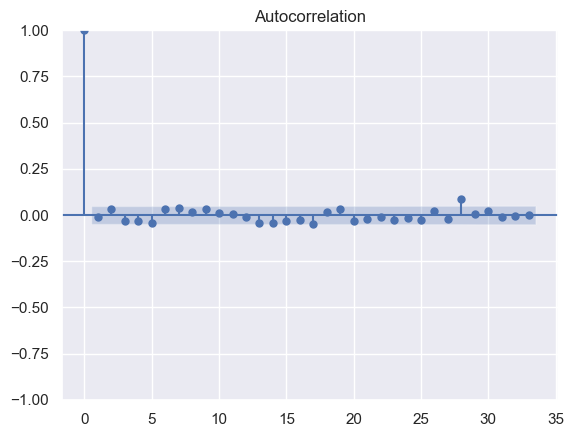

In [455]:
sm.graphics.tsa.plot_acf(residuals)
print("On remarque une absence d'autocorrélation.")

### Hypothèse 6 : absence de multicolinéarité

Le facteur d'inflation de la variance est une mesure de l'augmentation de la variance des estimations de paramètres si une variable supplémentaire est ajoutée à la régression linéaire. C'est une mesure de la multicolinéarité de la matrice des variables explicatives.

Une recommandation est que si le VIF est supérieur à 10, alors la variable explicative en question est fortement colinéaire avec les autres variables explicatives, et les estimations de paramètres auront de grandes erreurs en raison de cela.

Cf la documentation de statsmodels

In [456]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [457]:
vif = [
    variance_inflation_factor( sm.add_constant(X_train).values, i ) for i in range(sm.add_constant(X_train).shape[1])
    ]
# Rq: la fonction VIF attend une constante dans le dataframe d'entree 

c:\Users\jules\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\jules\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\jules\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\jules\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\jules\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero enc

In [458]:
print(
    pd.DataFrame({'VIF': vif[1:]}, index=X_train.columns)
    )

                              VIF
NbChildren               2.275998
Education_2n Cycle            inf
Education_Basic               inf
Education_Graduation          inf
Education_Master              inf
Education_PhD                 inf
Marital_Status_Divorced       inf
Marital_Status_Married        inf
Marital_Status_Single         inf
Marital_Status_Together       inf
Marital_Status_Widow          inf
Income                   6.679390
Year_Birth               1.224293
NbAcceptedCampaigns      1.356774
NumWebPurchases          2.358240
NumDealsPurchases        1.961293
NumWebVisitsMonth        2.516005
NumCatalogPurchases      2.813537
MntWines                 7.709258
MntFruits                2.670042
MntMeatProducts          7.505137
MntFishProducts          2.832624
MntSweetProducts         2.586210
MntGoldProds             1.995179


In [459]:
#TODO : Doit-on ignorer la mesure VIF sur les variables catégoriques ?

### Réduction du nombre de variables explicatives par le critère AIC

In [460]:
def aic(X, Y, regressor=""):  # entrer X le dataframe des variables explicatives,
    # Y la variable expliquée, et le regresseur utilisé
    aic_list = []

    for col in X.columns:
        X_temp = X.drop(col, axis=1)

        if regressor == "linearOLS":
            model_temp = sm.OLS(Y, sm.add_constant(X_temp)).fit()
        elif regressor == "GLMpoisson":
            model_temp = sm.GLM(Y, sm.add_constant(X_temp), family=sm.families.Poisson()).fit()

        else:
            return "Entrer un régresseur valide"

        aic_list.append([col, model_temp.aic])

    return aic_list

In [461]:
def stepwise(X, Y, regressor=""):  # entrer X le dataframe des variables explicatives,
    # Y la variable expliquée, et le regresseur utilisé

    if regressor == "linearOLS":
        current_aic = sm.OLS(Y, sm.add_constant(X)).fit().aic  # aic avec les variables actuelles
    elif regressor == "GLMpoisson":
        current_aic = sm.GLM(Y, sm.add_constant(X), family=sm.families.Poisson()).fit().aic
    else:
        return "Entrer un régresseur valide"

    aic_list = aic(
        X, Y, regressor
    )  # liste des aic par supression des variables une a une

    my_bool = 0  # pour indiquer si aucune variable n'est a enlever
    for i in range(
        len(aic_list)
    ):  # si l'aic diminue pour une variable supprimee, on enleve cette variable du df X

        if aic_list[i][1] < current_aic:
            del X[aic_list[i][0]]  # a l'interieur des crochets c'est une string
            my_bool = 1

    if my_bool == 0:
        return "L'algorithme stepwise est terminé."

In [462]:
print("Avant l'AIC, le nombre de variables explicatives est :", X_train.shape[1])

Avant l'AIC, le nombre de variables explicatives est : 24


In [463]:
while True:
    if (
        stepwise(X_train, Y_train, regressor="linearOLS")
        == "L'algorithme stepwise est terminé."
    ):
        break

In [464]:
stepwise(X_train, Y_train, regressor="linearOLS")

"L'algorithme stepwise est terminé."

In [465]:
print("Après l'AIC, le nombre de variables explicatives est :", X_train.shape[1])

Après l'AIC, le nombre de variables explicatives est : 21


In [466]:
# on refait les modèles après sélection de variables

X_test = X_test[
    X_train.columns
]  # homogénéisation des données de test et d'entraînement

fit = sm.OLS(Y_train, sm.add_constant(X_train)).fit()

model_multiple = LinearRegression().fit(X_train, Y_train)

### Distance de Cook

In [467]:
influence = fit.get_influence()
cooks = influence.cooks_distance

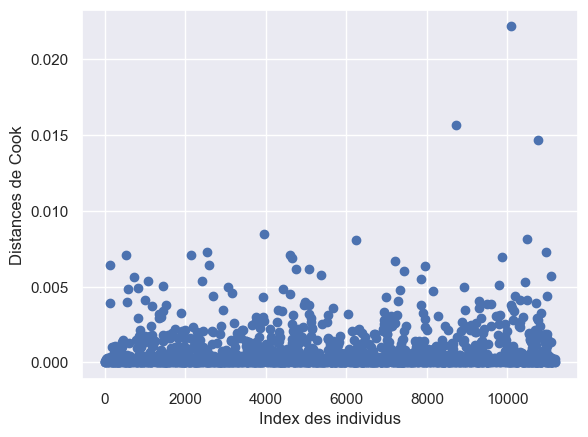

In [468]:
plt.scatter(X_train.index, cooks[0])
plt.xlabel("Index des individus")
plt.ylabel("Distances de Cook")
plt.show()

In [469]:
cooks_indexes = [i for i, x in enumerate(cooks[0] > 0.010) if x]
# détermine l'index dans la liste des individus dont la distance de cook dépasse 0.010

In [470]:
extreme_ind_list = [X_train.iloc[[i]].index[0] for i in cooks_indexes]

for ind in extreme_ind_list:
    print(ind)

10749
8720
10089


In [471]:
# TODO: supprimer les individus aux distances trop grandes

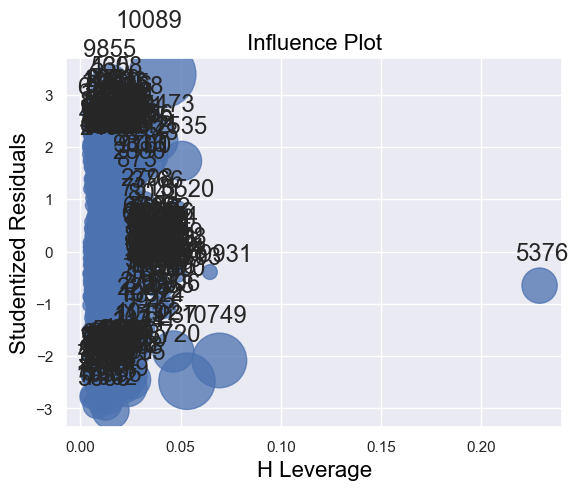

In [472]:
influence_plot(fit)
print("")

In [473]:
X_train.drop(extreme_ind_list + [5316], inplace = True)
Y_train.drop(extreme_ind_list + [5316], inplace = True)

In [474]:
# on refait les modèles après suppression des individus extremes

X_test = X_test[
    X_train.columns
]  # homogénéisation des données de test et d'entraînement

fit = sm.OLS(Y_train, sm.add_constant(X_train)).fit()

model_multiple = LinearRegression().fit(X_train, Y_train)


Les distances de Cook ont été largement réduites par la sélection de variables au critère AIC.

### Score du modèle

#### Qualité d'ajustement

In [475]:
print(f"Le R² du modèle vaut {model_multiple.score(X_train, Y_train)}")

Le R² du modèle vaut 0.6242305167672206


In [476]:
Y_train_hat = model_multiple.predict(X_train)

In [477]:
print(f"MSE = {mean_squared_error(Y_train, Y_train_hat)}")
print(f"RMSE = {mean_squared_error(Y_train, Y_train_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y_train, Y_train_hat)}")

MSE = 3.9360804541883434
RMSE = 1.9839557591308188
MAE = 1.4523972186837149


#### Qualité de prédiction

Train / test split

In [478]:
print(
    f"R² du modèle sur les données d'entraînement = {model_multiple.score(X_train, Y_train)}"
)
print(f"R² du modèle sur les données de test = {model_multiple.score(X_test, Y_test)}")

R² du modèle sur les données d'entraînement = 0.6242305167672206
R² du modèle sur les données de test = 0.6128955135414511


In [479]:
Y_test_hat = model_multiple.predict(X_test)

Text(0.5, 1.0, 'Valeurs prédites contre les vraies valeurs : données de test du modèle')

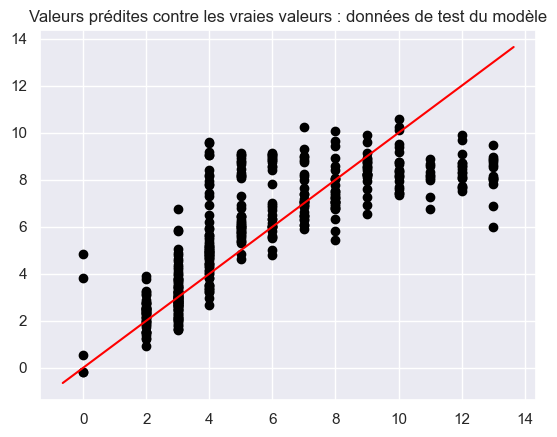

In [480]:
plt.scatter(Y_test, Y_test_hat, color="black")
abline(1, 0)
plt.title("Valeurs prédites contre les vraies valeurs : données de test du modèle")

In [481]:
print(f"MSE = {mean_squared_error(Y_test, Y_test_hat)}")
print(f"RMSE = {mean_squared_error(Y_test, Y_test_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y_test, Y_test_hat)}")

MSE = 3.9240052921121675
RMSE = 1.980910218084648
MAE = 1.4163168428875736


## Regression par modèle linéaire généralisé (GLM) : régression de Poisson

- Notons $Y$ notre variable d'intérêt et $X_1, ..., X_P$ nos variables explicatives.  
- On suppose que Y suit une loi de Poisson de paramètre $\lambda \in \mathbb{R+*}$


- On cherche à déterminer les coefficients de l'équation :

$\log(\mathrm{E}(Y|X)) = \log( \lambda ) = \alpha + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_P X_P $

Ce qui revient à déterminer les coefficients de l'équation :

$\lambda = e^{\alpha + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_P X_P}$

L'objectif de la régression est d'estimer $\alpha, \beta_1, ..., \beta_P$.  
Une fois ces coefficients estimés, on peut déterminer, pour un nouveau vecteur $X$,  
$E(Y|X) = e^{\alpha + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_P X_P}$

### Hypothèses à vérifier : 

<br>
- Avant de choisir la régression de Poisson :

1. La variable d'intérêt doit être une variable de comptage, à valeurs entières positives.  

2. La variable d'intérêt doit suivre une loi de Poisson :  
$Y | X ∼ Poisson(\lambda)$, où $\lambda \in \mathbb{R+*}$ , en particulier, la moyenne de Y doit être égale à sa variance.

3. $log(\lambda)$ est une fonction linéaire de $X_1, X_2, ... , X_P$  

<br>
- A posteriori :

4. $Cov(X_i, ε_j) = 0$, pour tout $i, j \in N \times N, i \neq j$ (exogénéité) et pour chaque variable explicative $X_p$

5. L'erreur suit une loi normale centrée i.e. $E(ε_i) = 0$

6. L’erreur est de variance constante (homoscédasticité)
i.e $Var(ε_i) = \sigma^2$, une constante

7. Les erreurs sont indépendantes (absence d'autocorrélation)
i.e. $Cov(εi, εj) = 0$, pour tout $i, j \in N \times N, i \neq j$

8. Absence de colinéarité entre les variables explicatives,
i.e. $X^t * X$ est régulière, $det(X^t * X) \neq 0$

In [107]:
X = df_reg[var_categoriques_reg + var_numeriques_reg]
Y = df["NumStorePurchases"]

### Hypothèses 1 : nature de la variable d'intérêt
La variable `NumberStorePurchases` désigne le nombre d'achat effectués en magasin. C'est bien une variable de comptage dont les valeurs sont entières et positives.

### Hypothèse 2 : loi de Poisson ?

In [108]:
from scipy.stats import poisson

[]

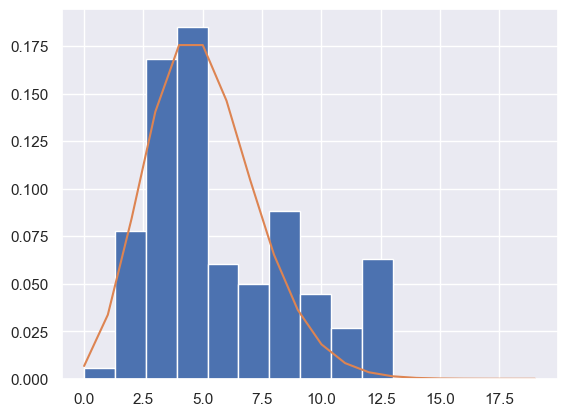

In [109]:
plt.hist(df["NumStorePurchases"], density=True)

# creating a numpy array for x-axis
x = np.arange(0, 20, 1)

# poisson distribution data for y-axis
y = poisson.pmf(x, mu=5)

plt.plot(x, y)
plt.plot()

In [110]:
from scipy.stats import kstest

In [111]:
ks_statistic, p_value = kstest(df["NumStorePurchases"], "poisson", args=(5, 0))
print(ks_statistic, p_value)

0.22139291784538884 1.6158613878843922e-88


In [112]:
print( "Variance de Y :", df["NumStorePurchases"].var(),
    ": Espérance de Y:", df["NumStorePurchases"].mean() ) 

Variance de Y : 10.4480633878631 : Espérance de Y: 5.79119804400978


In [113]:
print("La variance et l'espérance de Y ne sont pas égales. Cela peut dégrader la qualité de notre régression.")

La variance et l'espérance de Y ne sont pas égales. Cela peut dégrader la qualité de notre régression.


### Hypothèse 3 : lien linéaire entre $log(Y)$ et $X_1, ..., X_P$

In [114]:
null_index = Y[Y == 0].index
# on élimine les 0 pour appliquer le log

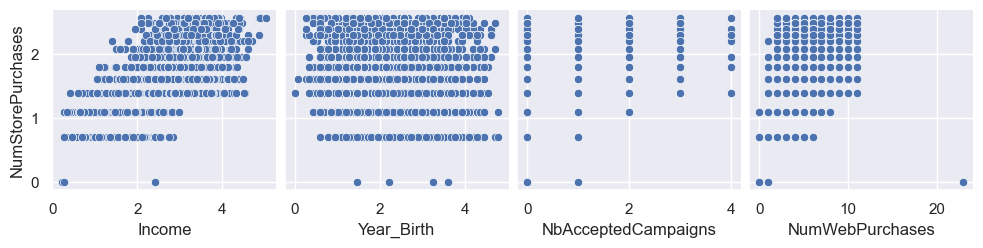

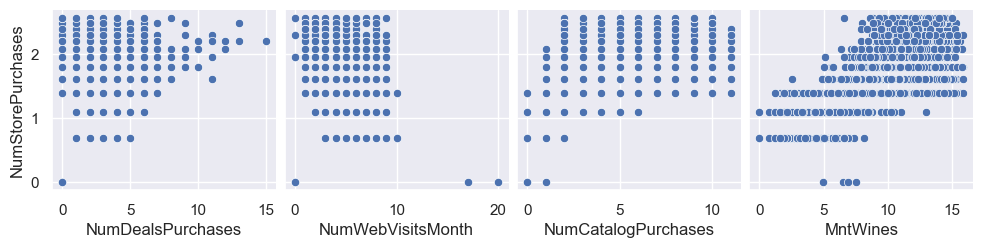

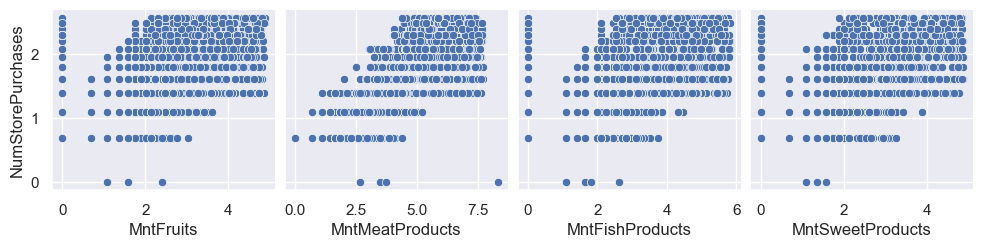

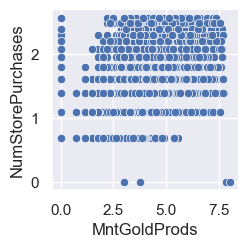

In [115]:
sns.pairplot(pd.concat([X.drop(index=null_index, axis = 0), np.log(Y.drop(index=null_index, axis = 0))], axis=1), x_vars=var_numeriques_reg[0:4], y_vars="NumStorePurchases")
sns.pairplot(pd.concat([X.drop(index=null_index, axis = 0), np.log(Y.drop(index=null_index, axis = 0))], axis=1), x_vars=var_numeriques_reg[4:8], y_vars="NumStorePurchases")
sns.pairplot(pd.concat([X.drop(index=null_index, axis = 0), np.log(Y.drop(index=null_index, axis = 0))], axis=1), x_vars=var_numeriques_reg[8:12], y_vars="NumStorePurchases")
sns.pairplot(pd.concat([X.drop(index=null_index, axis = 0), np.log(Y.drop(index=null_index, axis = 0))], axis=1), x_vars=var_numeriques_reg[12:], y_vars="NumStorePurchases")

In [116]:
for x in X[var_numeriques_reg].columns:
    corr = pearsonr(X.drop(index=null_index, axis = 0)[x], np.log(Y.drop(index=null_index, axis = 0)))
    print(
        "Le coefficient de corrélation linéaire entre log(Y) et",
        x,
        "vaut",
        corr[0],
        "la pvalue vaut",
        corr[1],
    )

Le coefficient de corrélation linéaire entre log(Y) et Income vaut 0.7212907584818407 la pvalue vaut 0.0
Le coefficient de corrélation linéaire entre log(Y) et Year_Birth vaut -0.17059998830731124 la pvalue vaut 9.471243731240196e-15
Le coefficient de corrélation linéaire entre log(Y) et NbAcceptedCampaigns vaut 0.2163925975607332 la pvalue vaut 5.591070429289367e-23
Le coefficient de corrélation linéaire entre log(Y) et NumWebPurchases vaut 0.5850784752204784 la pvalue vaut 3.848600096479464e-187
Le coefficient de corrélation linéaire entre log(Y) et NumDealsPurchases vaut 0.14664693230564244 la pvalue vaut 3.018774170323869e-11
Le coefficient de corrélation linéaire entre log(Y) et NumWebVisitsMonth vaut -0.46715997030157985 la pvalue vaut 8.733730148732481e-111
Le coefficient de corrélation linéaire entre log(Y) et NumCatalogPurchases vaut 0.6000939678284859 la pvalue vaut 2.954099184273152e-199
Le coefficient de corrélation linéaire entre log(Y) et MntWines vaut 0.8004513093275776 

Il existe bien un lien linéaire entre $log(Y)$ et les variables explicatives.

### Réalisation du modèle

In [117]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [118]:
from sklearn.linear_model import PoissonRegressor

In [119]:
model_poisson = PoissonRegressor().fit(X_train, Y_train)
Y_train_hat = model_poisson.predict(X_train)

Ici, notre fonction de lien est $f(\lambda) = log(\lambda)$  
Elle est utilisée par défaut par sci-kit learn 

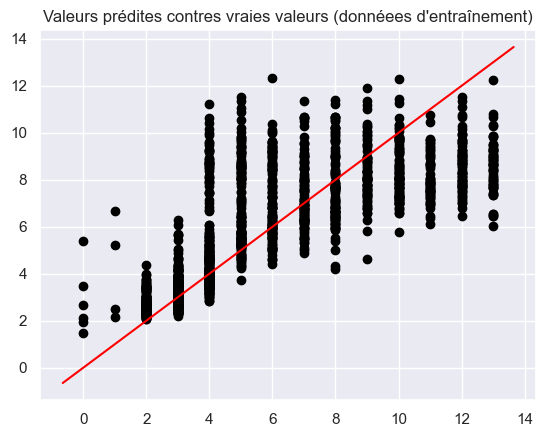

In [120]:
plt.scatter(Y_train, Y_train_hat, color="black")
plt.title("Valeurs prédites contres vraies valeurs (donnéees d'entraînement)")
abline(1, 0)

### Hypothèse 4 : exogénéité sur les variables numériques
(Cela n'a pas de sens de tester l'exogénéité sur les variables catégoriques car la notion de corrélation ne fonctionne pas avec celles-ci.)

In [121]:
residuals = Y_train - Y_train_hat

In [122]:
for x in X_train[var_numeriques_reg].columns:
    corr = pearsonr(X_train[x], residuals)
    print(
        "Le coefficient de corrélation entre",
        x,
        "et les residus vaut",
        corr[0],
        "et la pvalue associée vaut",
        corr[1],
    )

Le coefficient de corrélation entre Income et les residus vaut 0.010625313798863584 et la pvalue associée vaut 0.6675950565791144
Le coefficient de corrélation entre Year_Birth et les residus vaut 0.0011554074328647252 et la pvalue associée vaut 0.9627542156896914
Le coefficient de corrélation entre NbAcceptedCampaigns et les residus vaut -0.034708128411237424 et la pvalue associée vaut 0.16055521844200957
Le coefficient de corrélation entre NumWebPurchases et les residus vaut 0.0027448839094376893 et la pvalue associée vaut 0.9116646921633085
Le coefficient de corrélation entre NumDealsPurchases et les residus vaut 0.006362059368706813 et la pvalue associée vaut 0.7970743323439495
Le coefficient de corrélation entre NumWebVisitsMonth et les residus vaut -0.007989613629484303 et la pvalue associée vaut 0.7467573245271937
Le coefficient de corrélation entre NumCatalogPurchases et les residus vaut -0.00351015671838012 et la pvalue associée vaut 0.8871835024899596
Le coefficient de corrél

Il n'y a pas d'endogénéité.

### Hypothèse 5 : l'erreur suit une loi normale centrée i.e. $E(ε_i) = 0$

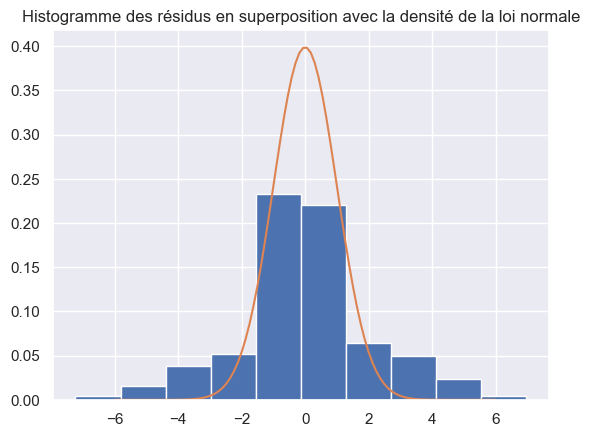

In [123]:
plt.hist(residuals, density=True)

x = np.linspace(-6, 6, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1))
plt.title("Histogramme des résidus en superposition avec la densité de la loi normale")
plt.show()

In [124]:
print("La moyenne des résidus vaut", statistics.mean(residuals))

La moyenne des résidus vaut -8.535620575225634e-07


On constate sur le qqplot que les points ne suivent pas la droite x = y


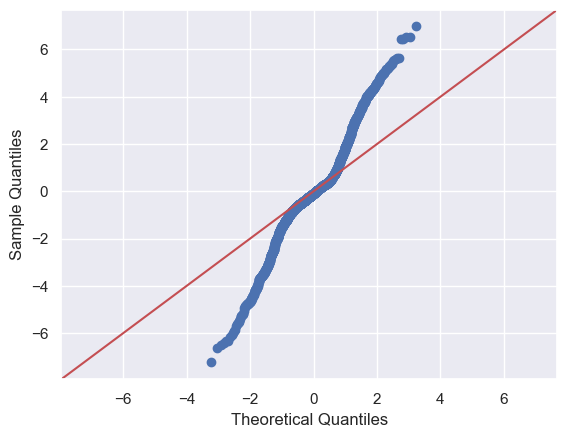

In [125]:
sm.qqplot(residuals, line="45")
print("On constate sur le qqplot que les points ne suivent pas la droite x = y")

In [126]:
print(
    "Un test de shapiro, pour tester l'hypothèse de normalité, nous donne une pvalue de",
    stats.shapiro(residuals)[1],
    ". On rejette l'hypothèse nulle et on conclut que les résidus ne suivent pas une loi normale.",
)

Un test de shapiro, pour tester l'hypothèse de normalité, nous donne une pvalue de 3.949026160283217e-20 . On rejette l'hypothèse nulle et on conclut que les résidus ne suivent pas une loi normale.


### Hypothèse 6 : homoscédasticité

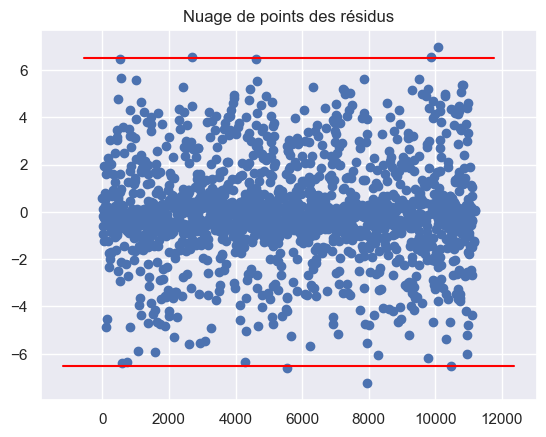

In [127]:
plt.plot(residuals, "bo")
plt.title("Nuage de points des résidus")
abline(0, 6.5)
abline(0, -6.5)

In [128]:
fit = sm.GLM(Y_train, sm.add_constant(X_train), family=sm.families.Poisson()).fit()

In [129]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      NumStorePurchases   No. Observations:                 1636
Model:                            GLM   Df Residuals:                     1613
Model Family:                 Poisson   Df Model:                           22
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3304.7
Date:                Sun, 26 Mar 2023   Deviance:                       928.71
Time:                        21:47:09   Pearson chi2:                     902.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.6944
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.6078      0.057     10.623      0.000       0.496       0.720
NbChildren                 -0.0313      0.022     -1.420      0.156      -0.075       0.012
Education_2n Cycle          0.1713      0.037      4.644      0.000       0.099       0.244
Education_Basic             0.1706      0.082      2.069      0.039       0.009       0.332
Education_Graduation        0.0931      0.027      3.454      0.001       0.040       0.146
Education_Master            0.0833      0.032      2.639      0.008       0.021       0.145
Education_PhD               0.0894      0.031      2.893      0.004       0.029       0.150
Marital_Status_Divorced     0.1321      0.031      4.298      0.000       0.072       0.192
Marital_Status_Married      0.1427      0.021      6.637      0.000       0.101       0.185
Marital_Status_Single       0.0959      0.025      3.792      0.000       0.046       0.146
Marital_Status_Together     0.1131      0.024      4.810      0.000       0.067       0.159
Marital_Status_Widow        0.1240      0.045      2.768      0.006       0.036       0.212
Income                      0.0366      0.027      1.352      0.176      -0.016       0.090
Year_Birth                  0.0046      0.011      0.421      0.674      -0.017       0.026
NbAcceptedCampaigns        -0.0722      0.016     -4.630      0.000      -0.103      -0.042
NumWebPurchases             0.0138      0.005      2.570      0.010       0.003       0.024
NumDealsPurchases           0.0277      0.007      3.755      0.000       0.013       0.042
NumWebVisitsMonth          -0.0403      0.007     -5.613      0.000      -0.054      -0.026
NumCatalogPurchases        -0.0237      0.006     -4.262      0.000      -0.035      -0.013
MntWines                    0.0767      0.007     11.415      0.000       0.063       0.090
MntFruits                   0.0132      0.011      1.237      0.216      -0.008       0.034
MntMeatProducts             0.0323      0.016      2.068      0.039       0.002       0.063
MntFishProducts             0.0163      0.010      1.709      0.087      -0.002       0.035
MntSweetProducts            0.0315      0.010      3.015      0.003       0.011       0.052
MntGoldProds                0.0022      0.008      0.290      0.771      -0.013       0.017
===========================================================================================
"""

In [130]:
res_names = ["F statistic", "p-value"]
gq_test = sms.het_goldfeldquandt(fit.resid_response, fit.model.exog)
lzip(res_names, gq_test)

[('F statistic', 1.0024932759776808), ('p-value', 0.48600195547705394)]

La pvalue du test de Goldfeld-Quandt est supérieure à 0.05 dont on conserve l'hypothèse d'homoscédasticité au seuil de 5% (et même au delà).

### Hypothèse 7 : absence d'autocorrélation

On remarque une absence d'autocorrélation.


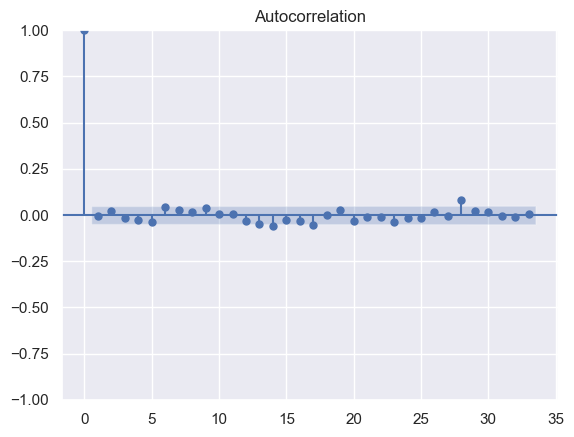

In [131]:
sm.graphics.tsa.plot_acf(residuals)
print("On remarque une absence d'autocorrélation.")

### Réduction du nombre de variables explicatives par le critère AIC

In [132]:
print("Avant l'AIC, le nombre de variables explicatives est :", X_train.shape[1])

Avant l'AIC, le nombre de variables explicatives est : 24


In [133]:
while True:
    if (
        stepwise(X_train, Y_train, regressor="GLMpoisson")
        == "L'algorithme stepwise est terminé."
    ):
        break

In [134]:
stepwise(X_train, Y_train, regressor="GLMpoisson")

"L'algorithme stepwise est terminé."

In [135]:
print("Après l'AIC, le nombre de variables explicatives est :", X_train.shape[1])

Après l'AIC, le nombre de variables explicatives est : 19


In [136]:
# on refait les modèles après sélection de variables

X_test = X_test[
    X_train.columns
]  # homogénéisation des données de test et d'entraînement

fit = sm.GLM(Y_train, sm.add_constant(X_train), family=sm.families.Poisson()).fit()

model_poisson = PoissonRegressor().fit(X_train, Y_train)

### Distance de Cook

In [137]:
influence = fit.get_influence()
cooks = influence.cooks_distance

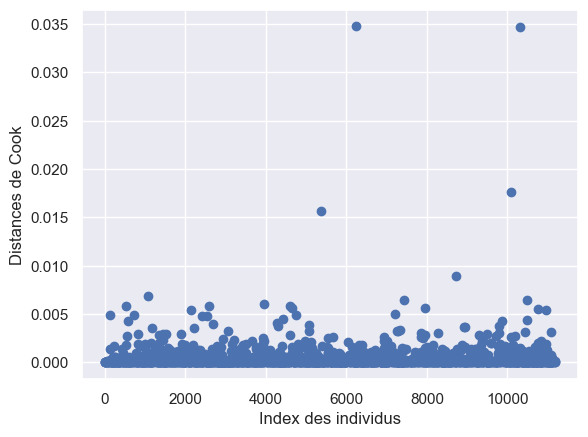

In [138]:
plt.scatter(X_train.index, cooks[0])
plt.xlabel("Index des individus")
plt.ylabel("Distances de Cook")
plt.show()

In [139]:
cooks_indexes = [i for i, x in enumerate(cooks[0] > 0.010) if x]
# détermine l'index dans la liste des individus dont la distance de cook dépasse 0.010

In [ ]:
extreme_ind_list = [X_train.iloc[[i]].index[0] for i in cooks_indexes]

for ind in extreme_ind_list:
    print(ind)

7441
1139
10311
5376
10089


In [ ]:
X_train.drop(extreme_ind_list, inplace = True)
Y_train.drop(extreme_ind_list, inplace = True)

In [ ]:
# on refait les modèles après suppression des individus extremes

X_test = X_test[
    X_train.columns
]  # homogénéisation des données de test et d'entraînement

fit = sm.GLM(Y_train, sm.add_constant(X_train), family=sm.families.Poisson()).fit()

model_poisson = PoissonRegressor().fit(X_train, Y_train)

In [141]:
# Remarque : statsmodels ne fait pas d'influence plot pour les modeles GLM

### Score du modèle

#### Qualité d'ajustement

In [142]:
print(f"Le R² du modèle vaut {model_poisson.score(X_train, Y_train)}")

Le R² du modèle vaut 0.6722859362161228


In [143]:
Y_train_hat = model_poisson.predict(X_train)

In [144]:
print(f"MSE = {mean_squared_error(Y_train, Y_train_hat)}")
print(f"RMSE = {mean_squared_error(Y_train, Y_train_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y_train, Y_train_hat)}")

MSE = 4.23438189367923
RMSE = 2.057761379188372
MAE = 1.4404232660819671


#### Qualité de prédiction

Train / test split

In [145]:
print(
    f"R² du modèle sur les données d'entraînement = {model_poisson.score(X_train, Y_train)}"
)
print(f"R² du modèle sur les données de test = {model_poisson.score(X_test, Y_test)}")

R² du modèle sur les données d'entraînement = 0.6722859362161228
R² du modèle sur les données de test = 0.6602526670073057


In [146]:
Y_test_hat = model_poisson.predict(X_test)

Text(0.5, 1.0, 'Valeurs prédites contre les vraies valeurs : données de test du modèle')

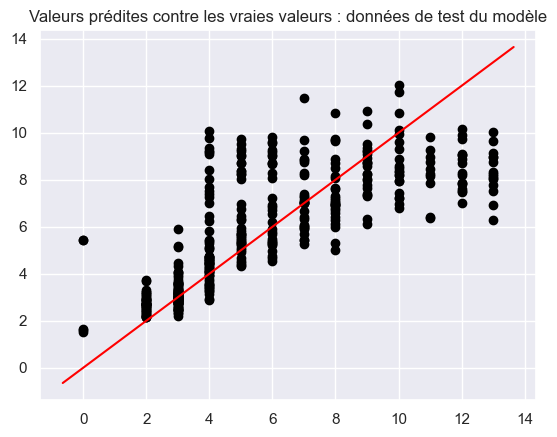

In [147]:
plt.scatter(Y_test, Y_test_hat, color="black")
abline(1, 0)
plt.title("Valeurs prédites contre les vraies valeurs : données de test du modèle")

In [148]:
print(f"MSE = {mean_squared_error(Y_test, Y_test_hat)}")
print(f"RMSE = {mean_squared_error(Y_test, Y_test_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y_test, Y_test_hat)}")

MSE = 4.06274228540152
RMSE = 2.015624539789472
MAE = 1.4041130022743948


In [149]:
print("Constante : ", model_poisson.intercept_)
for i in range(len(model_poisson.coef_)):
    print( f" beta_{i+1} = {model_poisson.coef_[i]} ")

Constante :  0.8834884551227272
 beta_1 = 0.023059222576859457 
 beta_2 = 0.0030335187195216075 
 beta_3 = -0.009422025976519276 
 beta_4 = -0.009387423248296198 
 beta_5 = -0.007238220033842077 
 beta_6 = 0.005213651297228667 
 beta_7 = 0.013152406034448068 
 beta_8 = -0.01254629900099877 
 beta_9 = -0.005540259915546421 
 beta_10 = -0.00023442637740804588 
 beta_11 = -0.04685110071303378 
 beta_12 = 0.01612313520677052 
 beta_13 = 0.020864406672305595 
 beta_14 = -0.043097009841234886 
 beta_15 = -0.019314724744649087 
 beta_16 = 0.07538181013751018 
 beta_17 = 0.041874372381125 
 beta_18 = 0.024560581544603763 
 beta_19 = 0.03619865290766216 


## Régression polynomiale

### Création des données

On conserve les mêmes variables explicatives et la même variable d'intérêt, mais en séparant les variables catégoriques des variables numériques qu'on transformera en monômes.  
Ceci car cela n'aurait pas de sens d'élever des variables catégoriques au carré et afin d'éviter l'explosion combinatoire.

In [150]:
X_ref = df_reg[var_numeriques_reg + var_categoriques_reg]

In [151]:
X_numeriques = df_reg[var_numeriques_reg]
X_categoriques = df_reg[var_categoriques_reg]
Y = df_reg["NumStorePurchases"]

In [152]:
from sklearn.preprocessing import PolynomialFeatures

In [153]:
# Transformer les données en matrice de caractéristiques polynomiales
poly = PolynomialFeatures(degree=2)

X_poly = poly.fit_transform(X_numeriques)
# Remarque : pendant la transformation, l'ordre des lignes est conservé, ce qui permettra de remettre les index

In [154]:
# trouvé sur stack over flow :
# permet de créer un df à partir de l'objet numpy array en sortie de la fonction fit_transform de sklearn

target_feature_names = ['x'.join(['{}^{}'.format(pair[0], pair[1]) for pair in tuple if pair[1] != 0])
                        for tuple in [zip(X.columns, p) for p in poly.powers_]]
# détermine les noms de colonnes


X_poly = pd.DataFrame(X_poly, columns=target_feature_names)

In [155]:
# je remets les indexes au df X_poly afin de pouvoir le concaténer avec le df des var categoriques avant la régression
X_poly = X_poly.set_index(pd.Index(X_categoriques.index))

In [156]:
X = pd.concat([X_poly, X_categoriques], axis = 1)

In [157]:
X.shape

(2045, 116)

Bien évidemment, il y a de la redondance dans les variables explicatives et donc de la colinéarité structurelle.

### Réalisation du modèle

In [158]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [159]:
model_poly = LinearRegression().fit(X_train, Y_train)
Y_train_hat = model_poly.predict(X_train)

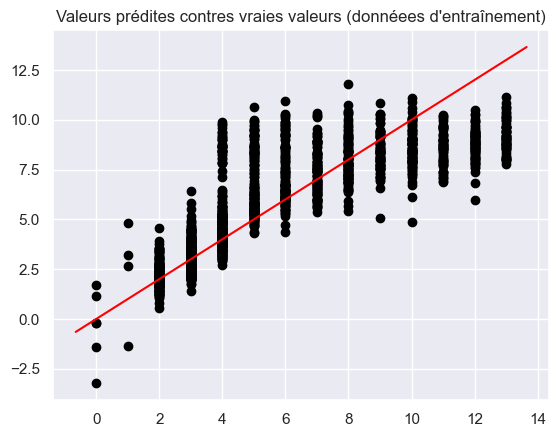

In [160]:
plt.scatter(Y_train, Y_train_hat, color="black")
plt.title("Valeurs prédites contres vraies valeurs (donnéees d'entraînement)")
abline(1, 0)

### Réduction du nombre de variables explicatives par le critère AIC

In [161]:
print("Avant l'AIC, le nombre de variables explicatives est :", X_train.shape[1])

Avant l'AIC, le nombre de variables explicatives est : 116


In [162]:
while True:
    if (
        stepwise(X_train, list(Y_train), regressor="linearOLS") # il faut transformer Y en liste sinon cela bug, je ne sais pas pourquoi
        == "L'algorithme stepwise est terminé."
    ):
        break

In [163]:
stepwise(X_train, list(Y_train), regressor="linearOLS")

"L'algorithme stepwise est terminé."

In [164]:
print("Après l'AIC, le nombre de variables explicatives est :", X_train.shape[1])

Après l'AIC, le nombre de variables explicatives est : 39


La procédure AIC a permi de purifier notre modèle de 77 variables explicatives.

In [165]:
# on refait les modèles après sélection de variables

X_test = X_test[
    X_train.columns
]  # homogénéisation des données de test et d'entraînement

fit = sm.OLS(list(Y_train), sm.add_constant(X_train)).fit() # comme il existe deja une constante dans X_train, statsmodels n'en rajoute pas une deuxieme

model_poly = LinearRegression().fit(X_train, Y_train)


### Distance de Cook

In [166]:
influence = fit.get_influence()
cooks = influence.cooks_distance

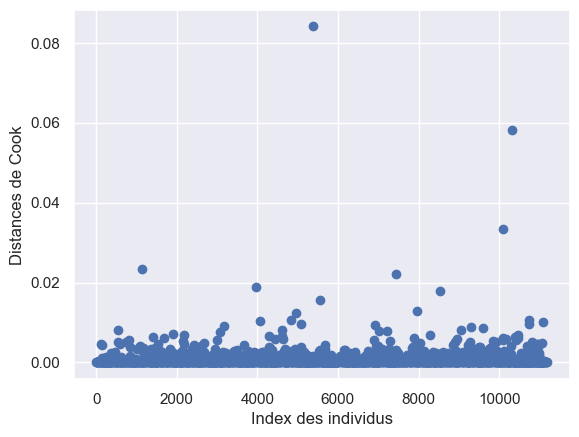

In [167]:
plt.scatter(X_train.index, cooks[0])
plt.xlabel("Index des individus")
plt.ylabel("Distances de Cook")
plt.show()

In [168]:
cooks_indexes = [i for i, x in enumerate(cooks[0] > 0.02) if x]
# détermine l'index dans la liste des individus dont la distance de cook dépasse 0.010

In [169]:
extreme_ind_list = [X_train.iloc[[i]].index[0] for i in cooks_indexes]

for ind in extreme_ind_list:
    print(ind)

7441
1139
10311
5376
10089


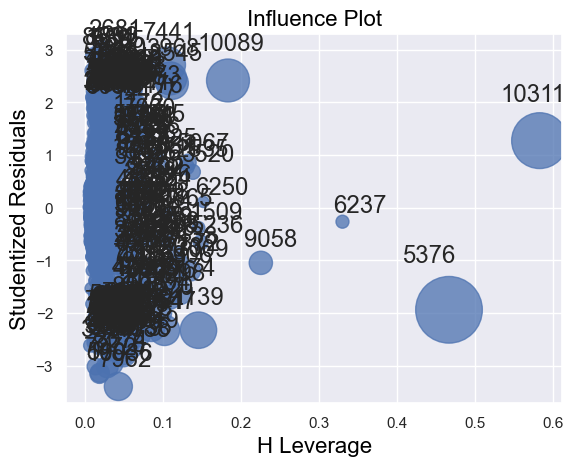

In [170]:
influence_plot(fit)
print("")

In [171]:
X_train.drop(extreme_ind_list + [6237, 9058], inplace = True)
Y_train.drop(extreme_ind_list + [6237, 9058], inplace = True)

In [192]:
# on refait les modèles après suppression des individus extremes

X_test = X_test[
    X_train.columns
]  # homogénéisation des données de test et d'entraînement

fit = sm.OLS(list(Y_train), sm.add_constant(X_train)).fit() # comme il existe deja une constante dans X_train, statsmodels n'en rajoute pas une deuxieme

model_poly = LinearRegression().fit(X_train, Y_train)


In [173]:
influence = fit.get_influence()
cooks = influence.cooks_distance

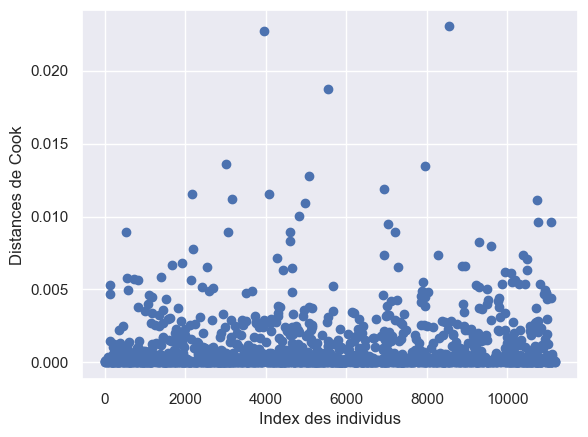

In [174]:
plt.scatter(X_train.index, cooks[0])
plt.xlabel("Index des individus")
plt.ylabel("Distances de Cook")
plt.show()

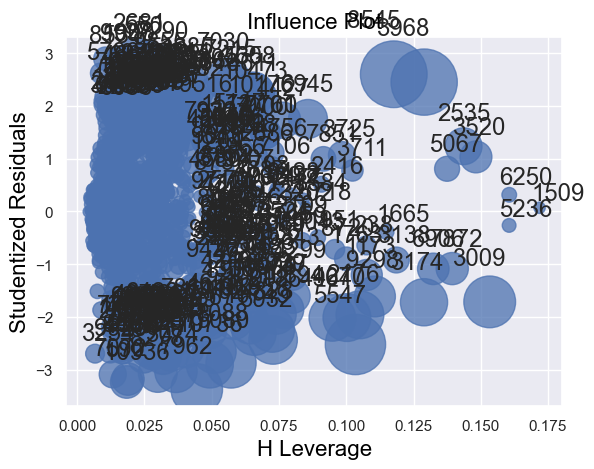

In [175]:
influence_plot(fit)
print("")

### Score du modèle

#### Qualité d'ajustement

In [176]:
print(f"Le R² du modèle vaut {model_poly.score(X_train, Y_train)}")

Le R² du modèle vaut 0.6476413084084092


In [177]:
Y_train_hat = model_poly.predict(X_train)

In [178]:
print(f"MSE = {mean_squared_error(Y_train, Y_train_hat)}")
print(f"RMSE = {mean_squared_error(Y_train, Y_train_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y_train, Y_train_hat)}")

MSE = 3.682492441187941
RMSE = 1.9189821367558222
MAE = 1.3861731961799497


#### Qualité de prédiction

Train / test split

In [179]:
print(
    f"R² du modèle sur les données d'entraînement = {model_poly.score(X_train, Y_train)}"
)
print(f"R² du modèle sur les données de test = {model_poly.score(X_test, Y_test)}")

R² du modèle sur les données d'entraînement = 0.6476413084084092
R² du modèle sur les données de test = 0.4625581418507382


In [208]:
Y_test_hat = model_poly.predict(X_test)

Text(0.5, 1.0, 'Valeurs prédites contre les vraies valeurs : données de test du modèle')

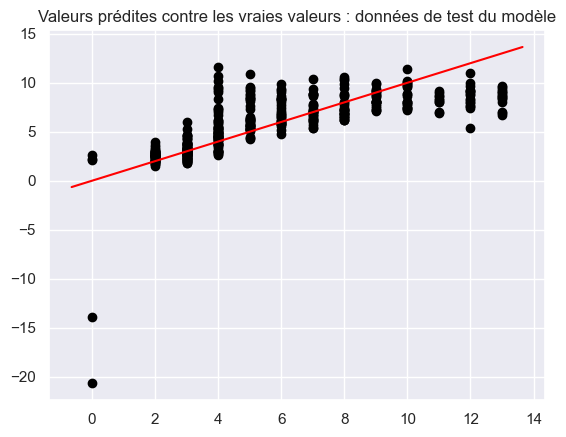

In [209]:
plt.scatter(Y_test, Y_test_hat, color="black")
abline(1, 0)
plt.title("Valeurs prédites contre les vraies valeurs : données de test du modèle")

In [210]:
print(f"MSE = {mean_squared_error(Y_test, Y_test_hat)}")
print(f"RMSE = {mean_squared_error(Y_test, Y_test_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y_test, Y_test_hat)}")

MSE = 5.447946922222313
RMSE = 2.334083743618106
MAE = 1.4665834079331774


La mesure de la qualité d'ajustement à nos données de test est biaisée par des valeurs prédites extrêmes.

<Axes: ylabel='Count'>

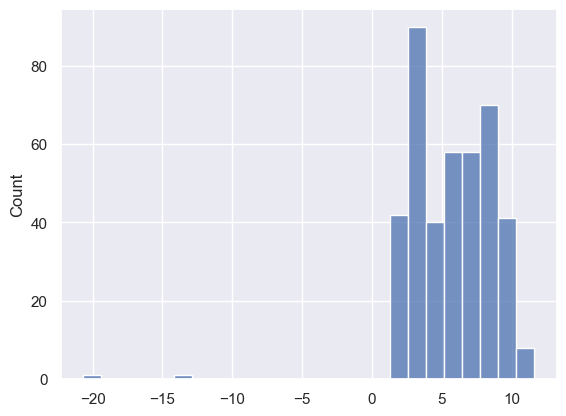

In [183]:
sns.histplot(Y_test_hat)

In [184]:
Y_test_hat_new = Y_test_hat[Y_test_hat > 0]
Y_test_new = Y_test[Y_test_hat > 0]

Text(0.5, 1.0, 'Valeurs prédites contre les vraies valeurs : données de test du modèle')

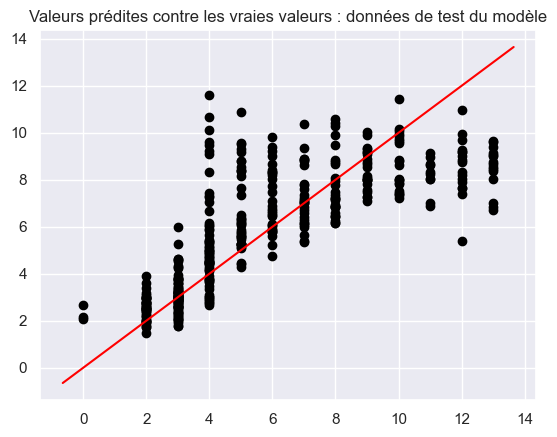

In [185]:
plt.scatter(Y_test_new, Y_test_hat_new, color="black")
abline(1, 0)
plt.title("Valeurs prédites contre les vraies valeurs : données de test du modèle")

In [186]:
print(f"MSE = {mean_squared_error(Y_test_new, Y_test_hat_new)}")
print(f"RMSE = {mean_squared_error(Y_test_new, Y_test_hat_new, squared=False)}")
print(f"MAE = {mean_absolute_error(Y_test_new, Y_test_hat_new)}")

MSE = 3.9480406255814446
RMSE = 1.9869676961595135
MAE = 1.388757476051957


Corrigé de ces erreurs, le modèle polynomial est notre meilleur modèle.

In [227]:
print("Constante : ", model_poly.intercept_)
for i in range(len(model_poly.coef_)):
    print( f" beta_{i+1} = {model_poly.coef_[i]} ")

Constante :  1.9412727630882598
 beta_1 = -0.34177742407732276 
 beta_2 = 0.4525233151934455 
 beta_3 = -0.2894485673614224 
 beta_4 = 0.11294329163268033 
 beta_5 = -0.09062832483019413 
 beta_6 = 0.2511670226866624 
 beta_7 = 0.07631971219996375 
 beta_8 = 0.06544708283800774 
 beta_9 = -0.08567752731398443 
 beta_10 = 0.13063390113753295 
 beta_11 = -0.028460000865691372 
 beta_12 = -0.2561371685047879 
 beta_13 = -0.1557043380868738 
 beta_14 = -0.029136575054494417 
 beta_15 = 0.09257197407812019 
 beta_16 = 0.04560719332101195 
 beta_17 = 0.024246103969511514 
 beta_18 = -0.04735619031189191 
 beta_19 = -0.04760784547243308 
 beta_20 = 0.04554970438219338 
 beta_21 = -0.08569360215521027 
 beta_22 = -0.045898054136420736 
 beta_23 = 0.09120473065882373 
 beta_24 = -0.07527026077763277 
 beta_25 = 0.1538791087395371 
 beta_26 = 0.08543577434262617 
 beta_27 = -0.08318916331568614 
 beta_28 = 0.10973429750914315 
 beta_29 = 0.29530826071955557 
 beta_30 = 0.19164987142871942 
 beta